In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [2]:
%matplotlib qt
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.9s remaining:    5.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 133.69it/s]

Using control points [0.00000000e+00 0.00000000e+00 7.93055086e-09]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


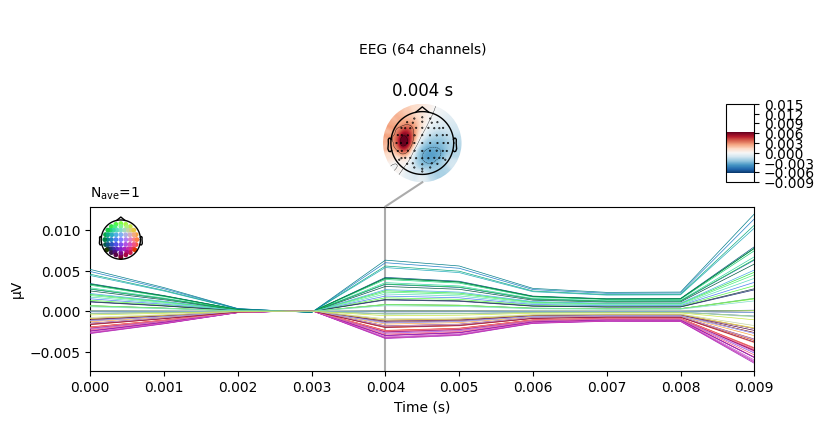

In [27]:
settings = dict(number_of_sources=1, extents=1, duration_of_trial=0.01, target_snr=1e99)
# settings = dict(number_of_sources=5, extents=(1, 25), duration_of_trial=0.2, target_snr=1e99, amplitudes=100)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
B = evoked.data
S = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Gamma Maximum a-Posteriori

**db** number of sensors  
**ds** number of dipoles  
**n** number of time points  

**B** EEG matrix  
**S** source matrix  
**C** Covariance Matrix  
**Cb** Empirical (Data) Covariance Matrix  
**Sigma_b** Model Covariance Matrix  
**Sigma_s** Source Covariance Matrix  
**Sigma_e** Noise Covariance Matrix  


**E-Step**: find mean and cov of S given gamma_hat  
**M-Step**: update gammas  


In [ ]:
# Parameters
alpha = 1e-6

# Some initialization
L = deepcopy(leadfield)
db, n = B.shape
ds = L.shape[1]

# some helper functions
def frob(x):
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    return np.sqrt(np.trace(x@x.T))

# Common average reference
B -= B.mean(axis=0)
L -= L.mean(axis=0)
# L /= np.linalg.norm(L, axis=0)
# Source Components
C = []
for i in range(ds):
    Ci = np.zeros((ds, ds))
    Ci[i,i] = 1
    C.append( Ci )
# Data Covariance Matrix
Cb = B @ B.T
gammas = np.ones(ds)
sigma_e = alpha * np.identity(db)  
sigma_s = np.identity(ds) # identity leads to weighted minimum L2 Norm solution
sigma_b = sigma_e + L @ sigma_s @ L.T
# r = np.ones(ds)  # THIS IS prob wrong

In [ ]:
max_iter = 50
sigma_b_inv = np.linalg.inv(sigma_b)

for k in range(max_iter):
    old_gammas = deepcopy(gammas)
    print(i, ": ", np.linalg.norm(gammas), " atoms")
    
    # term_1 = (gammas[i]/np.sqrt(n)) * np.sqrt(np.sum((L.T @ sigma_b_inv @ B )**2, axis=1))
    term_1 = (gammas/np.sqrt(n)) * np.sqrt(np.sum((L.T @ sigma_b_inv @ B )**2, axis=1))
    term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))
    
    gammas = term_1 * term_2
    if np.linalg.norm(gammas) == 0:
        gammas = old_gammas
        break
    # gammas /= np.linalg.norm(gammas)

gammas_final = gammas / gammas.max()
sigma_s_hat = np.diag(gammas_final) @ sigma_s  #  np.array([gammas_final[i] * C[i] for i in range(ds)])
S = sigma_s_hat @ L.T @ np.linalg.inv(sigma_e + L @ sigma_s_hat @ L.T) @ B

#  Source-Space Maximum A Posteriori

In [ ]:
# Parameters
alpha = 1e-6
p = 0

# Some initialization
L = deepcopy(leadfield)
db, n = B.shape
ds = L.shape[1]

# Common average reference
B -= B.mean(axis=0)
L -= L.mean(axis=0)

# Data Covariance Matrix
gammas = np.ones(ds)
sigma_e = alpha * np.identity(db)  
sigma_s = np.identity(ds) # identity leads to weighted minimum L2 Norm solution
sigma_b = sigma_e + L @ sigma_s @ L.T
# r = np.ones(ds)  # THIS IS prob wrong

max_iter = 50
sigma_b_inv = np.linalg.inv(sigma_b)

for k in range(max_iter):
    old_gammas = deepcopy(gammas)
    print(i, ": ", np.linalg.norm(gammas), " atoms")
    # for i in range(ds):
    #     l_i = L[:, i][:, np.newaxis]
    #     gammas[i] = ((1/n) * np.sqrt(np.sum(( gammas[i] * l_i.T @ sigma_b_inv @ B )**2 )))**((2-p)/2)

    gammas = ((1/n) * np.sqrt(np.sum(( np.diag(gammas) @ L.T @ sigma_b_inv @ B )**2, axis=1)))**((2-p)/2)

    if np.linalg.norm(gammas) == 0:
        gammas = old_gammas
        break
    # gammas /= np.linalg.norm(gammas)

gammas_final = gammas / gammas.max()
sigma_s_hat = np.diag(gammas_final) @ sigma_s  #  np.array([gammas_final[i] * C[i] for i in range(ds)])
S = sigma_s_hat @ L.T @ np.linalg.inv(sigma_e + L @ sigma_s_hat @ L.T) @ B

# Variational Bayes: Mean-Field

0 :  35.832945734337834  atoms
1 :  5.172077810369971e-09  atoms
2 :  6.998778948792975e-18  atoms
3 :  1.434244099610673e-26  atoms
4 :  3.089190526856403e-35  atoms
5 :  6.701294064367276e-44  atoms
6 :  1.4587393731929808e-52  atoms
7 :  3.181587622273089e-61  atoms
8 :  6.951111345972702e-70  atoms
9 :  1.523000821868388e-78  atoms
10 :  3.337098458584375e-87  atoms
11 :  7.322140120232366e-96  atoms
12 :  1.6093156552846143e-104  atoms
13 :  3.5425294491228214e-113  atoms
14 :  7.808532893829828e-122  atoms
15 :  1.7219686150811234e-130  atoms
16 :  3.801812111852977e-139  atoms
17 :  8.393822622112264e-148  atoms
18 :  1.8572184230355686e-156  atoms
Using control points [0.        0.        0.4482938]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
EEG channel type selected for re-referencing
Applying average refer

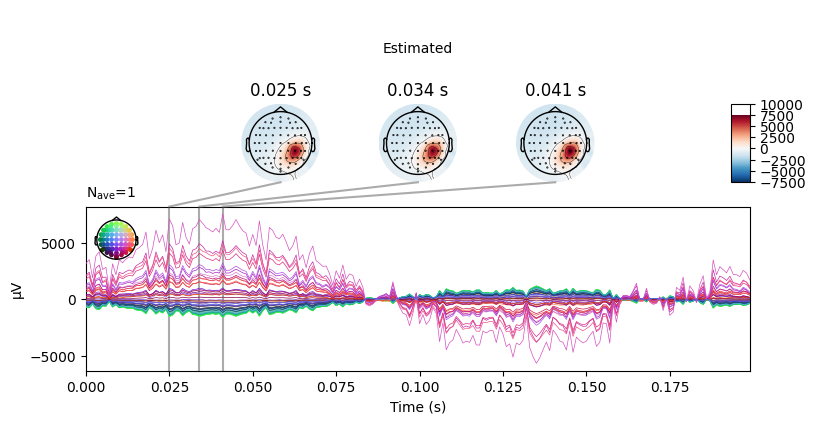

Using control points [0.         0.         0.29092894]


In [6]:
# Parameters
alpha = 0#1e-6
p = 0

# Some initialization
L = deepcopy(leadfield)
db, n = B.shape
ds = L.shape[1]

# Common average reference
B -= B.mean(axis=0)
L -= L.mean(axis=0)

# Data Covariance Matrix
gammas = np.ones(ds)
sigma_e = alpha * np.identity(db)  
sigma_s = np.identity(ds) # identity leads to weighted minimum L2 Norm solution
sigma_b = sigma_e + L @ sigma_s @ L.T
# r = np.ones(ds)  # THIS IS prob wrong

max_iter = 50
sigma_b_inv = np.linalg.inv(sigma_b)

for k in range(max_iter):
    old_gammas = deepcopy(gammas)
    print(k, ": ", np.linalg.norm(gammas), " atoms")
    # for i in range(ds):
    #     l_i = L[:, i][:, np.newaxis]
    #     gammas[i] = ((1/n) * np.sqrt(np.sum(( gammas[i] * l_i.T @ sigma_b_inv @ B )**2 )))**((2-p)/2)

    gammas = ((1/n) * np.sqrt(np.sum(( np.diag(gammas) @ L.T @ sigma_b_inv @ B )**2, axis=1)))**((2-p)/2)

    if np.linalg.norm(gammas) == 0:
        gammas = old_gammas
        break
    # gammas /= np.linalg.norm(gammas)

gammas_final = gammas / gammas.max()
sigma_s_hat = np.diag(gammas_final) @ sigma_s  #  np.array([gammas_final[i] * C[i] for i in range(ds)])
S = sigma_s_hat @ L.T @ np.linalg.inv(sigma_e + L @ sigma_s_hat @ L.T) @ B

stc_ = stc.copy()
stc_.data = S #/ abs(S).max()
stc_.plot(**pp, brain_kwargs=dict(title="Variational Bayes Mean Field"))

evoked_ = mne.EvokedArray(L @ S, info).set_eeg_reference("average")
evoked_.plot_joint(title="Variational Bayes Mean Field")

# Expectation-Maximization Champagne

0 1.0


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1 0.9971856135566334
2 0.9942827467356345
3 0.9913083594616612
4 0.9881541666931002
5 0.9849299110892178
6 0.9816108884243756
7 0.9783280770864968
8 0.9748897355913926
9 0.9713011389735027
10 0.9677133614060262
11 0.9639608635294691
12 0.9599754733054586
13 0.9559098416537539
14 0.9518848209573174
15 0.9477792567645984
16 0.9436145993590679
17 0.9392790908560416
18 0.9349906396688393
19 0.9305080551708902
20 0.9259196178196586
21 0.9211787230619971
22 0.9163631861043209
23 0.911583935209397
24 0.9067968567132609
25 0.901733335921021
26 0.8966642609058302
27 0.8914238065814328
28 0.8860345558380792
29 0.8806235980339174
30 0.8749082635220253
31 0.8692643223288105
32 0.8635975724132394
33 0.8576583111966506
34 0.8517528934619735
35 0.8457269358065689
36 0.8395510298240569
37 0.8334524501100546
38 0.8270435550223743
39 0.8207166896477602
40 0.8140211642905065
41 0.8075693797940285
42 0.8005287097905984
43 0.7936240124875354
44 0.7866791690222925
45 0.7794371832424963
46 0.7725699782227311

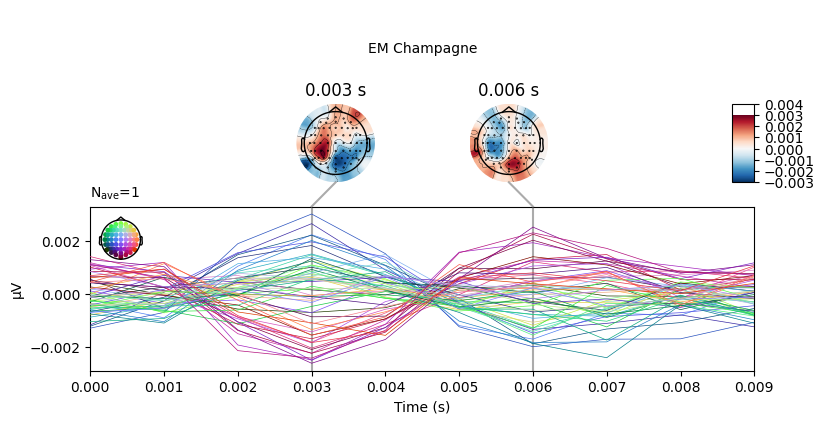

In [6]:
from scipy.stats import pearsonr
Y = evoked.data
Y -= Y.mean(axis=0)
C = Y@Y.T
max_eig = np.linalg.svd(C)[1].max()

L = deepcopy(leadfield)
vec = lambda x: x.reshape(x.shape[0] * x.shape[1], 1)

n_chans, n_dipoles = L.shape
n_times = Y.shape[1]

# Initialize Variables
max_iter = 300
convergence_crit = 1e-99
eps = 1e-6
alpha = 0.01 * max_eig
last_gamma = 1e99
I = np.identity(n_chans)
gammas = np.ones(n_dipoles)
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
nulled_idc = np.array([])
for i in range(max_iter):
    print(i, gammas.max())
    old_gammas = deepcopy(gammas)
    right_term = (mu_x**2).sum(axis=1) / n_times
    # update gammas
    gammas = np.diagonal(Sigma_x) + right_term
    gammas[gammas<0] = 0
    gammas[np.isnan(gammas)] = 0
    
    # Thresholding
    gammas[gammas<eps] = 0
    
    # Convergence Check
    gammas_norm = np.linalg.norm(gammas)
    r = pearsonr(gammas, old_gammas)[0]
    # print(gammas_norm, 1-r)
    if gammas_norm == 0 or (1-r) < convergence_crit or gammas.max() > old_gammas.max():
        print("breaking ", gammas_norm, 1-r)
        gammas = old_gammas
        break
    
    # update rest
    Gamma = np.diag(gammas)
    Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
    mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
    
# update rest
# gammas[nulled_idc] = 0
gammas[gammas<eps] = 0

gammas /= gammas.max()
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y


stc_ = stc.copy()
stc_.data = mu_x
stc_.plot(**pp, brain_kwargs=dict(title="EM Champagne"))

evoked_ = mne.EvokedArray(L @ mu_x, info).set_eeg_reference("average")
evoked_.plot_joint(title="EM Champagne")

# EM-Champagne pruned

In [62]:
np.diag(Sigma_x @ Sigma_x.T / n_times).shape

(1284,)

In [5]:
from scipy.stats import pearsonr
Y = evoked.data
Y -= Y.mean(axis=0)
C = Y@Y.T
max_eig = np.linalg.svd(C)[1].max()

L = deepcopy(leadfield)
L -= L.mean(axis=0)
# L = (L.T / np.linalg.norm(L.T, axis=0)).T
vec = lambda x: x.reshape(x.shape[0] * x.shape[1], 1)

n_chans, n_dipoles = L.shape
n_times = Y.shape[1]

# Initialize Variables
max_iter = 130
convergence_crit = 1e-99
eps = 1e-3
alpha = 0.01 * max_eig

active_set = np.arange(n_dipoles)
I = np.identity(n_chans)
gammas = np.ones(n_dipoles)
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
gidx = np.abs(gammas) > eps
n_active = deepcopy(n_dipoles)
losses = [1e99,]
for i in range(max_iter):
    print(i, gidx.sum())
    old_gammas = deepcopy(gammas)
    old_gidx = deepcopy(gidx)
    old_active_set = deepcopy(active_set)
    
    right_term = (mu_x**2).mean(axis=1)
    # update gammas
    gammas = np.diagonal(Sigma_x) + right_term

    gammas = np.sqrt(np.diag(Sigma_x @ Sigma_x.T) / np.diag(Gamma @ L.T @ Sigma_y_inv @ L))
    # print(gammas.shape)
    # gammas = np.sqrt(gammas)
    gammas[gammas<0] = 0
    gammas[np.isnan(gammas)] = 0
    
    # Pruning
    gidx = np.abs(gammas) > eps
    active_set = active_set[gidx]
    gammas = gammas[gidx]
    # update only active gammas (once set to zero it stays at zero)
    if n_active > len(active_set):
        n_active = active_set.size
        L = L[:, gidx]

    

    # Convergence Check
    # gammas_norm = np.linalg.norm(gammas)
    # r = pearsonr(gammas, old_gammas)[0]
    # print(gammas_norm, 1-r)
    # if gammas_norm == 0:
    #     # print("breaking ", gammas_norm, 1-r)
    #     gammas = old_gammas
    #     break
    # update rest
    Gamma = np.diag(gammas)
    Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
    mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
    
    loss = np.log(np.linalg.norm(Sigma_y)) + np.mean(np.stack([yy[:, np.newaxis].T @ Sigma_y_inv @ yy[:, np.newaxis] for yy in Y.T], axis=0), axis=0)
    print(loss)
    losses.append(abs(loss))

    # if losses[-2] < losses[-1]:
    #     print("breaking")
    #     gammas = old_gammas
    #     gidx = old_gidx
    #     active_set = old_active_set
    #     break
    
    # e_bar = Y - (L @ mu_x)
    # noise_cov = np.sqrt(np.diag(e_bar @ e_bar.T / n_times) / np.diag(Sigma_y_inv))
    # eps = 0.2 * np.mean(np.diag(noise_cov))

# update rest
gammas_full = np.zeros(n_dipoles)
gammas_full[active_set] = gammas

# gammas /= gammas.max()
Gamma = np.diag(gammas_full)
Sigma_y = (alpha**2) * I + leadfield @ Gamma @ leadfield.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
mu_x = Gamma @ leadfield.T @ Sigma_y_inv @ Y


# stc_ = stc.copy()
# stc_.data[:, 0] = gammas / abs(gammas).max()
# stc_.plot(**pp, brain_kwargs=dict(title="EM-Champagne"))

stc_ = stc.copy()
stc_.data = mu_x / abs(mu_x).max()
stc_.plot(**pp, brain_kwargs=dict(title="EM-Champagne"))


0 1284
[[8.39631511]]
1 1284
[[10.29602351]]
2 1284
[[12.12441681]]
3 1284
[[13.87920757]]
4 1284
[[15.59951649]]
5 1284
[[17.27944177]]
6 1284
[[18.92435337]]
7 1284
[[20.55863107]]
8 1284
[[22.18442583]]
9 1284
[[23.78851673]]
10 1284
[[25.36511946]]
11 1284
[[26.9439515]]
12 1284
[[28.52985451]]
13 1284
[[30.11504988]]
14 1284
[[31.68423397]]
15 1284
[[33.24721723]]
16 1284
[[34.81392786]]
17 1284
[[36.38355138]]
18 1284
[[37.96539274]]
19 1284
[[39.51702881]]
20 1284
[[41.08146715]]
21 1284
[[42.64533308]]
22 1284
[[44.21386665]]
23 1284
[[45.77191319]]
24 1284
[[47.34571547]]
25 1284
[[48.89216734]]
26 1284
[[50.46667918]]
27 1284
[[52.03213744]]
28 1284
[[53.60201894]]
29 1284
[[55.17069072]]
30 1284
[[56.7385965]]
31 1284
[[58.3112617]]
32 1284
[[59.87911293]]
33 1284
[[61.44962435]]
34 1284
[[63.00565239]]
35 1284
[[64.57021077]]
36 1284
[[66.12654656]]
37 1284
[[67.70491688]]
38 1284
[[69.26922379]]
39 1284
[[70.83339074]]
40 1284
[[72.4049871]]
41 1284
[[73.9620204]]
42 1284


KeyboardInterrupt: 

# Majorization-Minimization Champagne

0
1


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Using control points [6.58195611e-10 1.21075913e-09 6.33373236e-09]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
No projector specified for this dataset. Please consider the method self.add_proj.


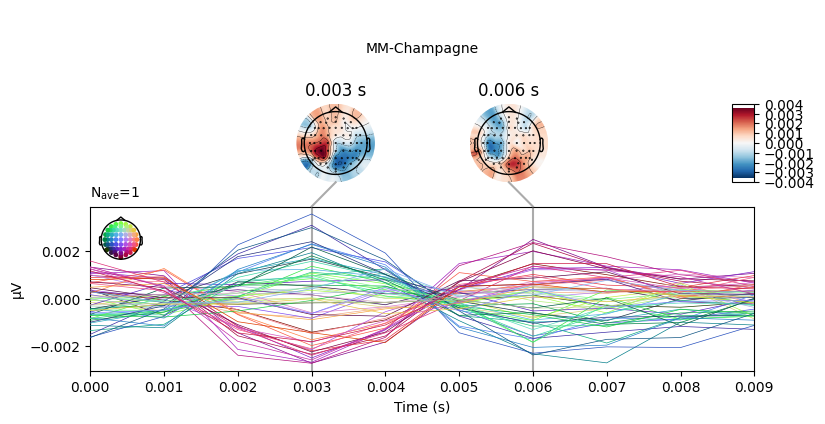

Using control points [6.44141052e-10 1.18838630e-09 7.39962014e-09]


In [9]:
from scipy.stats import pearsonr
Y = evoked.data
Y -= Y.mean(axis=0)
L = deepcopy(leadfield)
C = Y@Y.T
max_eig = np.linalg.svd(C)[1].max()

vec = lambda x: x.reshape(x.shape[0] * x.shape[1], 1)

n_chans, n_dipoles = L.shape
n_times = Y.shape[1]

# Initialize Variables
max_iter = 100
convergence_crit = 1e-99
alpha = 10 * max_eig
I = np.identity(n_chans)
gammas = np.ones(n_dipoles)

Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y

for i in range(max_iter):
    print(i)
    old_gammas = deepcopy(gammas)
    z_n = np.diagonal(L.T @ Sigma_y_inv @ L)
    upper_term = (mu_x**2).sum(axis=1) / n_times
    # update gammas
    gammas = upper_term / z_n
    gammas[gammas<0] = 0
    gammas = np.sqrt(gammas)
    gammas[np.isnan(gammas)] = 0

    # Convergence Check
    gammas_norm = np.linalg.norm(gammas)
    r = pearsonr(gammas, old_gammas)[0]
    if gammas_norm == 0 or (1-r) < convergence_crit:
        print("breaking")
        gammas = old_gammas
        break
    # update rest
    Gamma = np.diag(gammas)
    Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
    
# update rest
gammas /= gammas.max()
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y

    
# stc_ = stc.copy()
# stc_.data[:, 0] = gammas / abs(gammas).max()
# stc_.plot(**pp, brain_kwargs=dict(title="MM-Champagne"))

stc_ = stc.copy()
stc_.data = mu_x #/ abs(mu_x).max()
stc_.plot(**pp, brain_kwargs=dict(title="MM-Champagne"))

evoked_ = mne.EvokedArray(L @ mu_x, info).set_eeg_reference("average")
evoked_.plot_joint(title="MM-Champagne")

# LowSNR-MM-Champagne

max gamma:  5.288303128736516e-10
0
max gamma:  7.246196975785324e-10
0
max gamma:  1.205860633568534e-09
0
max gamma:  1.7700825249988839e-09
0
max gamma:  2.508407925816414e-09
0
max gamma:  3.0362219405333235e-09
0
max gamma:  3.112925694992441e-09
0
max gamma:  3.7141167918974816e-09
0
max gamma:  3.887577371131101e-09
3
max gamma:  4.045795254370432e-09
5
max gamma:  4.096738948078382e-09
10
max gamma:  5.277139170090095e-09
20
max gamma:  4.764091343645305e-09
33
max gamma:  5.6019202610002594e-09
50
max gamma:  5.617618370479249e-09
74
max gamma:  5.739974273666348e-09
102
max gamma:  5.376859846251136e-09
118
max gamma:  5.977409678337153e-09
145
max gamma:  6.103607841367875e-09
165
max gamma:  5.974674088804477e-09
188
max gamma:  7.3668813271865474e-09
218
max gamma:  6.7510423917838125e-09
265
max gamma:  7.269743917959204e-09
294
max gamma:  7.777900101757496e-09
314
max gamma:  6.522117956819784e-09
340
max gamma:  6.941472729948828e-09
361
max gamma:  6.202182767367503e-

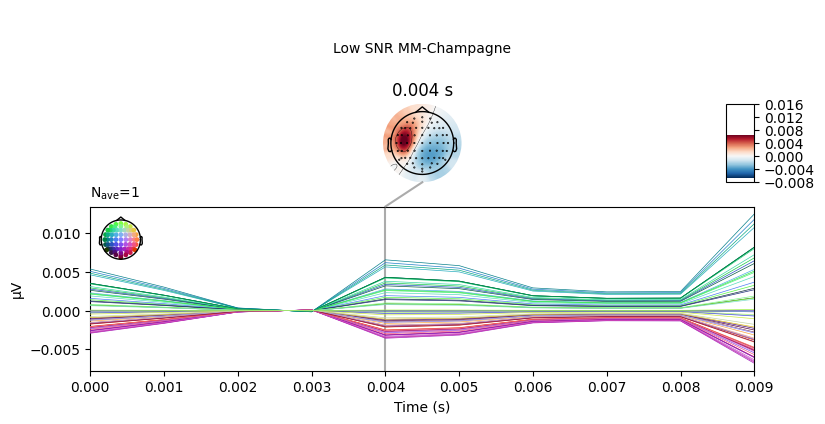

Using control points [2.96019856e-12 1.38147185e-11 5.07424305e-09]


In [30]:
from scipy.stats import pearsonr
from scipy.sparse import coo_matrix, kron

Y = evoked.data
Y -= Y.mean(axis=0)
L = deepcopy(leadfield)

def frob(x):
    return np.sqrt(np.trace(x@x.T))
C = Y@Y.T
max_eig = np.linalg.svd(L@L.T)[1].max()
vec = lambda x: x.reshape(x.shape[0] * x.shape[1], 1)

n_chans, n_dipoles = L.shape
n_times = Y.shape[1]

# Initialize Variables
max_iter = 500
convergence_crit = 1e-99
pruning_thresh = 1e-6
alpha = 0.000 * max_eig
I = np.identity(n_chans)
It = np.identity(n_times)

# D = kron(L, It)
gammas = np.ones(n_dipoles)
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y

for i in range(max_iter):
    old_gammas = deepcopy(gammas)

    for i in range(len(gammas)):
        ll = L[:, i][:, np.newaxis]
        LTL = np.diagonal(ll.T@ll)
        gammas[i] = np.sqrt((((mu_x[i]**2).sum()) / n_times) / LTL)

    gammas[np.isnan(gammas)] = 0
    print("max gamma: ", gammas.max())
    # gammas[gammas<pruning_thresh] = 0
    print((gammas==0).sum())
    

    # Check if gammas went to zero
    if np.linalg.norm(gammas) == 0:
        print("breaking")
        gammas = old_gammas
        break
    # update rest
    Gamma = np.diag(gammas)
    Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
    
# update rest
gammas /= gammas.max()
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y

stc_ = stc.copy()
stc_.data = mu_x
stc_.plot(**pp, brain_kwargs=dict(title="Low SNR MM-Champagne"))

evoked_ = mne.EvokedArray(L @ mu_x, info).set_eeg_reference("average")
evoked_.plot_joint(title="Low SNR MM-Champagne")

# T-EM Champagne

In [7]:
import numpy as np
n_dipoles = 1284

mu_x = np.random.randn(n_dipoles, 100)
gammas = np.ones(n_dipoles)
It = np.identity(100)

# covs = mu_x[n]
# (mu_x[n].T @ mu_x).shape

np.stack([(mu_x[nn, np.newaxis].T * mu_x[nn, np.newaxis]) / gammas[nn] for nn in range(n_dipoles)], axis=0).sum(axis=0) + 

(100, 100)

0


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


C:\Users\Lukas\AppData\Local\Temp\ipykernel_6156\1158536355.py:54: RuntimeWarning: invalid value encountered in divide
  B_hat = B_hat = np.stack([(mu_x[nn, np.newaxis].T * mu_x[nn, np.newaxis]) / gammas[nn] for nn in range(n_dipoles)], axis=0).sum(axis=0) + theta*It


261
breaking  0.0 nan
Using control points [2.48903364e-06 3.20446988e-06 7.07321707e-05]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
No projector specified for this dataset. Please consider the method self.add_proj.


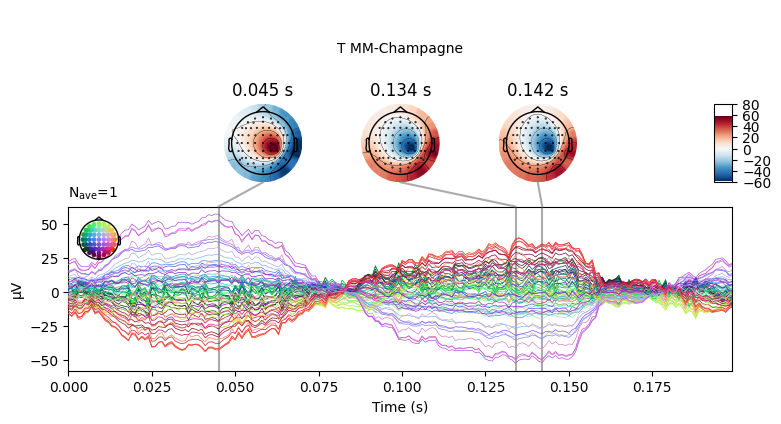

Using control points [1.51698589e-06 2.00719277e-06 3.47495041e-05]


In [17]:
from scipy.stats import pearsonr
Y = evoked.data
Y -= Y.mean(axis=0)
C = Y@Y.T
max_eig = np.linalg.svd(C)[1].max()

L = deepcopy(leadfield)
vec = lambda x: x.reshape(x.shape[0] * x.shape[1], 1)
def frob(x):
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    return np.sqrt(np.trace(x@x.T))
n_chans, n_dipoles = L.shape
n_times = Y.shape[1]

# Initialize Variables
max_iter = 1000
convergence_crit = 1e-99
alpha = 0.00 * max_eig
theta = 0.00 * max_eig
I = np.identity(n_chans)
gammas = np.ones(n_dipoles)

Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
B_hat = np.stack([(mu_x[nn, np.newaxis].T * mu_x[nn, np.newaxis]) / gammas[nn] for nn in range(n_dipoles)], axis=0).sum(axis=0) + theta*It
B = B_hat / frob(B_hat)
for i in range(max_iter):
    print(i)
    old_gammas = deepcopy(gammas)
    right_term = np.diagonal(mu_x @ np.linalg.inv(B) @ mu_x.T)
    # update gammas
    gammas = np.diagonal(Sigma_x) + right_term
    gammas[gammas<0] = 0
    gammas[np.isnan(gammas)] = 0
    
    # Convergence Check
    gammas_norm = np.linalg.norm(gammas)
    r = pearsonr(gammas, old_gammas)[0]
    # print(gammas_norm, 1-r)
    if gammas_norm == 0 or (1-r) < convergence_crit:
        print("breaking ", gammas_norm, 1-r)
        gammas = old_gammas
        break
    # update rest
    Gamma = np.diag(gammas)
    Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
    mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
    B_hat = B_hat = np.stack([(mu_x[nn, np.newaxis].T * mu_x[nn, np.newaxis]) / gammas[nn] for nn in range(n_dipoles)], axis=0).sum(axis=0) + theta*It
    B = B_hat / frob(B_hat)
    
# update rest
gammas /= gammas.max()
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y


stc_ = stc.copy()
stc_.data = mu_x #/ abs(mu_x).max()
stc_.plot(**pp, brain_kwargs=dict(title="T MM-Champagne"))

evoked_ = mne.EvokedArray(L @ mu_x, info).set_eeg_reference("average")
evoked_.plot_joint(title="T MM-Champagne")

# Plot

In [ ]:
stc_ = stc.copy()
stc_.data = S / abs(S).max()
stc_.plot(**pp, brain_kwargs=dict(title="Esimated"))

evoked_ = mne.EvokedArray(L @ S, info).set_eeg_reference("average")
evoked_.plot_joint(title="Estimated")